In [9]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import numpy as np
import pymysql

In [10]:
# 경기도 해외 확진자, 확진일 Data Set
sql_gginfo_select = "select cfm_date, cum_cfm_cnt from GGExternal"

conn = pymysql.connect(
    user='root', 
    passwd='1234', 
    host='127.0.0.1', 
    db='covid19', 
    charset='utf8'
)

with conn.cursor() as cur:
    cur.execute(sql_gginfo_select)
    data = cur.fetchall()
    
data = pd.DataFrame(data)
data.columns=['stdDay', 'defCnt']
data.head()

,stdDay,defCnt
0,2020-01-26,1
1,2020-01-27,2
2,2020-01-28,2
3,2020-01-29,2
4,2020-01-30,2


In [16]:
# 경기도 코로나19 확진자 추이
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data.stdDay,
        y=data.defCnt,
        name='Confirmed in Gyeonggi-do(External)'
    )
)

fig

In [12]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임 생성
df_prophet = data.rename(columns={
    'stdDay': 'ds',
    'defCnt': 'y'
})

df_prophet.tail()

,ds,y
235,2020-09-17,564
236,2020-09-18,567
237,2020-09-19,569
238,2020-09-20,570
239,2020-09-21,572


In [13]:
# 모델 생성
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

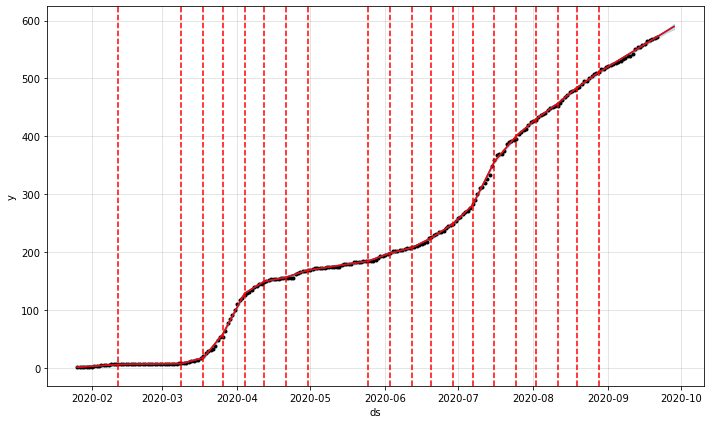

In [14]:
# changepoint 그래프 반영
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [15]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
240,2020-09-22,574.435537,571.901477,576.695063
241,2020-09-23,576.988984,574.363957,579.318849
242,2020-09-24,579.542431,576.961437,582.388839
243,2020-09-25,582.095878,579.113171,584.882287
244,2020-09-26,584.649325,581.517498,588.114039
245,2020-09-27,587.202772,583.212726,591.187419
246,2020-09-28,589.756219,584.689459,594.730272
